# Setup and Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set
import warnings
import re
from pandas.io import gbq
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import xgboost
import pickle
from sklearn.model_selection import ParameterSampler
from scipy import sparse
#Custom Python Module with functions specifically for this project
import ChicagoDataCleaningFunctions as cd

# Get the Data

In [3]:
#Read the data in from Google BigQuery
chicago_data = """
                    SELECT unique_key, date, primary_type, location_description, 
                            arrest, domestic, community_area, year
                    FROM `gdac-327115.Chicago.chicago2`
                    WHERE year >= 2011
               """
chicago_data = gbq.read_gbq(chicago_data, project_id="gdac-327115")

In [4]:
#Read in an Excel file with a one to one mapping between Chicago community areas and districts
chicago_districts = pd.read_excel("ChicagoCommunityAreas.xlsx")

In [5]:
#Data type can't be joined on an int
chicago_districts.community_area = chicago_districts["community_area"].astype("string")
chicago_data.community_area = chicago_data["community_area"].astype("string")

In [6]:
#Outer join the two data sets
chicago = chicago_data.merge(chicago_districts, how="outer", left_on="community_area", right_on="community_area", )

In [7]:
#Drop the community area variable since we have a community name variable
chicago.drop("community_area", axis = 1, inplace = True)

# Split the Data into Training and Test Sets

In [43]:
chicago_train = chicago.loc[chicago["year"] != 2021]
chicago_test = chicago.loc[chicago["year"] == 2021]

# Clean the Training Data

In [44]:
%%capture --no-stdout
cd.chicago_data_cleaner(chicago_train, verbose=True)

Cleaning Started...

Successfully Cleaned Primary Type
Successfully Imputed Location
Successfully Cleaned Location
Successfully Added Month Column
Successfully Added Hour Column
Successfully Cleaned Community

Data Set Successfully Cleaned!


# Prepare the Data for Modeling 

Since all of our variables are categorical, we'll need to one-hot-encode all of them. Also, note that we will not be using year as a feature. This is because the final test set will only use data from 2021. Future considerations could treat this problem as a time series problem. 

In [12]:
#Check if the test set contains data from the full year
chicago_test.loc[:, "date"].dt.month. \
                                value_counts(). \
                                reset_index(). \
                                rename(columns={"index":"Month", "date":"Count"}). \
                                sort_values(by = "Month")

,Month,Count
5,1,16008
8,2,12852
6,3,15709
7,4,15279
4,5,17493
2,6,18468
0,7,18898
3,8,18110
1,9,18632
9,10,5507


We are reminded that our final test set does not include the final two months of the year. Thus, when we transform the Month variable we'll have to drop the "11" and "12" columns to ensure that our training data matches up with the test data. We'll do this in a function. 

In [9]:
def prepare_chicago_train(df, attribs):
    """
    This function is just a convenient wrapper around the ColumnTransformer method for OneHotEncoding categorical features
    specific to the training data
    
    df: DataFrame
    attribs: Columns specified to be transformed. Expected data structure is a list
    
    returns: X(Sparse Matrix): y(Series)
    """
    #Get a separate list for the time variables
    date_attribs = [attribs.pop(attribs.index("Month")), attribs.pop(attribs.index("Hour"))]
    
    #One hot encode the variables
    cat_encoder = OneHotEncoder()
    X_sub = cat_encoder.fit_transform(df[attribs])
    
    #One hot encode the time variables but produce a dense matrix to drop the 11th and 12th values from month
    cat_encoder = OneHotEncoder(sparse = False)
    X_date = sparse.csr_matrix(np.delete(cat_encoder.fit_transform(df[date_attribs]), [10, 11], axis = 1))
    
    #Horizontally stack the two back together
    X = sparse.hstack((X_sub, X_date))
    y = (df["arrest"] == True).astype(np.int)
    
    return X, y
    

In [13]:
def prepare_chicago_test(df, attribs):
    """
    This function is just a convenient wrapper around the ColumnTransformer method for OneHotEncoding categorical features
    specific to the test data
    
    df: DataFrame
    attribs: Columns specified to be transformed. Expected data structure is a list
    
    returns: X(Sparse Matrix): y(Series)
    """
    cat_encoder = OneHotEncoder()
    X = cat_encoder.fit_transform(df[attribs])
    
    y = (df["arrest"] == True).astype(np.int)
    return X, y

# Building the Models

We'll only consider traditional models in Part 1. Part 2 will specifically use deep learning techniques

Now that we've prepared the data, we can build the models and get a baseline accuracy and F1-score. We'll also time each model to get an idea of the time it takes to train. 

Since the data is so large, we'll only consider a small random subset to fit different models quickly. Note that it is important to stratify on arrests since we have strong class imbalance. 

In [53]:
#List of variables to use in the model
cat_attribs = ["primary_type", "location_description", "domestic", "district_name", "community_name", "Month", "Hour"]

#Prepare the data for modelling
X, y = prepare_chicago_train(df = chicago_train, attribs = cat_attribs.copy())

#Subset the data twice to quickly fit models
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size =.80, random_state = 42, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size =.10, random_state = 42, stratify = y_train)

In [54]:
#Check the shapes
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(506634, 181)
(56293, 181)
(506634,)
(56293,)


# Baseline Scores

### Logistic Regression

In [55]:
log_reg = LogisticRegression(max_iter = 10000)

In [56]:
%%time
#Results
y_train_pred = cross_val_predict(log_reg, X_train, y_train, cv = 5)
lr_cv_f1 = np.round(f1_score(y_train, y_train_pred), 4) * 100
lr_cv_acc = np.round(accuracy_score(y_train, y_train_pred), 4) * 100
print(f'Logistic Regression 5-fold CV Baseline F1-Score: {lr_cv_f1:.2f}%')
print(f'Logistic Regression 5-fold CV Baseline Accuracy: {lr_cv_acc:.2f}%')

Logistic Regression 5-fold CV Baseline F1-Score: 65.31%
Logistic Regression 5-fold CV Baseline Accuracy: 86.66%
Wall time: 52.7 s


### Naive Bayes

In [57]:
nb_clf = GaussianNB()

In [58]:
%%time
#Results
#Naive Bayes API expects arrays to be passed
y_train_pred = cross_val_predict(nb_clf, X_train.toarray(), np.array(y_train), cv = 5)
nb_cv_f1 = np.round(f1_score(y_train, y_train_pred), 4) * 100
nb_cv_acc = np.round(accuracy_score(y_train, y_train_pred), 4) * 100
print(f'Naive Bayes 5-fold CV Baseline F1-Score: {nb_cv_f1:.2f}%')
print(f'Naive Bayes 5-fold CV Baseline Accuracy: {nb_cv_acc:.2f}%')

Naive Bayes 5-fold CV Baseline F1-Score: 63.42%
Naive Bayes 5-fold CV Baseline Accuracy: 85.42%
Wall time: 14 s


### Linear SVC

In [59]:
svc_clf = LinearSVC()

In [60]:
%%time
#Results
y_train_pred = cross_val_predict(svc_clf, X_train, y_train, cv = 5)
svc_cv_f1 = np.round(f1_score(y_train, y_train_pred), 4) * 100
svc_cv_acc = np.round(accuracy_score(y_train, y_train_pred), 4) * 100
print(f'Linear SVC 5-fold CV Baseline F1-Score: {svc_cv_f1:.2f}%')
print(f'Linear SVC 5-fold CV Baseline Accuracy: {svc_cv_acc:.2f}%')

Linear SVC 5-fold CV Baseline F1-Score: 65.69%
Linear SVC 5-fold CV Baseline Accuracy: 86.98%
Wall time: 1min 45s


### Random Forest

In [61]:
rf_clf = RandomForestClassifier(n_estimators = 50, max_depth=25, random_state=42)

In [65]:
%%time
#Results
y_train_pred = cross_val_predict(rf_clf, X_train, y_train, cv = 3)
rf_cv_f1 = np.round(f1_score(y_train, y_train_pred), 5) * 100
rf_cv_acc = np.round(accuracy_score(y_train, y_train_pred), 5) * 100
print(f'Random Forest 3-fold CV Baseline F1-Score: {rf_cv_f1:.2f}%')
print(f'Random Forest 3-fold CV Baseline Accuracy: {rf_cv_acc:.2f}%')

Random Forest 3-fold CV Baseline F1-Score: 66.62%
Random Forest 3-fold CV Baseline Accuracy: 87.52%
Wall time: 6min 50s


### XGBoost

In [62]:
xgb_clf = xgboost.XGBClassifier(use_label_encoder=False, objective = "binary:logistic")

In [63]:
%%time
#Results
y_train_pred = cross_val_predict(xgb_clf, X_train, y_train, cv = 5)
xgb_cv_f1 = np.round(f1_score(y_train, y_train_pred), 4) * 100
xgb_cv_acc = np.round(accuracy_score(y_train, y_train_pred), 4) * 100

[17:32:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:32:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:32:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:32:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [64]:
print(f'XGBoost 5-fold CV Baseline F1-Score: {xgb_cv_f1:.2f}%')
print(f'XGBoost 5-fold CV Baseline Accuracy: {xgb_cv_acc:.2f}%')

XGBoost 5-fold CV Baseline F1-Score: 68.59%
XGBoost 5-fold CV Baseline Accuracy: 87.83%


### Voting Ensemble

In [66]:
lr_clf = LogisticRegression(max_iter = 10000)
nb_clf = GaussianNB()
svc_clf = LinearSVC()
rf_clf = RandomForestClassifier(n_estimators=50, max_depth=25, random_state=42)
xgb_clf = xgboost.XGBClassifier(use_label_encoder=False, objective = "binary:logistic")

voting_clf = VotingClassifier(
    estimators = [("lr", lr_clf), ("nb", nb_clf), ("svc", svc_clf), ("rf", rf_clf), ("xgb", xgb_clf)],
    voting = "hard"
)


In [67]:
%%time
#Results
y_train_pred = cross_val_predict(voting_clf, X_train.toarray(), np.array(y_train), cv = 3)
vt_cv_f1 = np.round(f1_score(y_train, y_train_pred), 4) * 100
vt_cv_acc = np.round(accuracy_score(y_train, y_train_pred), 4) * 100

[17:45:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:48:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:52:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 10min 59s


In [69]:
print(f'Voting Ensemble 3-fold CV Baseline F1-Score: {vt_cv_f1:.2f}%')
print(f'Voting Ensemble 3-fold CV Baseline Accuracy: {vt_cv_acc:.2f}%')

Voting Ensemble 3-fold CV Baseline F1-Score: 65.75%
Voting Ensemble 3-fold CV Baseline Accuracy: 87.14%


### Preliminary Results

All six models give similar accuracy scores of 87% with Naive Bayes being a bit lower at 85%. However, the models have more variation in their F1-score. All but the Naive Bayes model have F1-scores around 66% but Naive Bayes only has an F1-score of 63%.

# Fine Tune the System

Now that we have some preliminary results, we can go ahead and fine tune the hyparameters. Naive Bayes does not have any hyperparameters that need to be tuned. 

### Hyperparameter Tuning for Logistic Regression

In [70]:
%%time
#Randomly search through the hyperparameter space
param_distribs = {
    "C" : np.linspace(0, 10, 10000),
    }
lr_clf = LogisticRegression(penalty = "l2", solver = "lbfgs", max_iter=100000)

lr_rnd_search_cv = RandomizedSearchCV(lr_clf, param_distribs, n_iter = 15,
                                   cv=2 ,scoring = 'f1', random_state=42, n_jobs = -1)

lr_rnd_search_cv.fit(X_train, y_train)

print(lr_rnd_search_cv.best_params_)
print(lr_rnd_search_cv.best_score_)

{'C': 5.191519151915192}
0.6529097904207977
Wall time: 2min 33s


In [71]:
#Save the results in a dataframe
lr_rnd_search_df = pd.DataFrame(lr_rnd_search_cv.cv_results_)
#Rank the results by score
lr_rnd_search_df[["param_C", "mean_test_score"]].sort_values(by = "mean_test_score", ascending = False).head()

,param_C,mean_test_score
3,5.191519,0.652910
5,6.265627,0.652906
9,8.322832,0.652906
7,4.426443,0.652903
8,5.578558,0.652903


### Hyperparameter Tuning for Linear SVC

In [74]:
%%time
#Randomly search through the hyperparameter space
param_distribs = {
    "C" : np.linspace(0.1, 15, 100),
    }
svc_clf = LinearSVC(max_iter=10000)

svc_rnd_search_cv = RandomizedSearchCV(svc_clf, param_distribs, n_iter = 15,
                                   cv=2 ,scoring = 'f1', random_state=42, n_jobs = -1)

svc_rnd_search_cv.fit(X_train, y_train)

print(svc_rnd_search_cv.best_params_)
print(svc_rnd_search_cv.best_score_)

{'C': 12.59191919191919}
0.6568822542397925
Wall time: 39min 14s


In [75]:
#Save the results
svc_rnd_search_df = pd.DataFrame(svc_rnd_search_cv.cv_results_)
#Rank by score
svc_rnd_search_df[["param_C", "mean_test_score"]].sort_values(by = "mean_test_score", ascending = False).head()

,param_C,mean_test_score
0,12.591919,0.656882
1,8.076768,0.656882
2,10.635354,0.656882
3,6.872727,0.656882
4,6.722222,0.656882


### Hyperparameter Tuning for RandomForest

In [83]:
%%time
#Randomly search through the hyperparameter space
param_distribs = {
    "n_estimators": np.arange(25, 150),
    "max_depth": np.arange(10, 30)
    }
rf_clf = RandomForestClassifier()

rf_rnd_search_cv = RandomizedSearchCV(rf_clf, param_distribs, n_iter = 10,
                                   cv=2 ,scoring = 'f1', random_state=42)

rf_rnd_search_cv.fit(X_train, y_train)

print(rf_rnd_search_cv.best_params_)
print(rf_rnd_search_cv.best_score_)

{'n_estimators': 69, 'max_depth': 27}
0.669302172076826
Wall time: 30min 32s


In [84]:
#Save the results
rf_rnd_search_df = pd.DataFrame(rf_rnd_search_cv.cv_results_)
tuned_params = ["param_n_estimators", "param_max_depth", "mean_test_score"]
#Rank by score
rf_rnd_search_df[tuned_params].sort_values(by = "mean_test_score", ascending = False).head()

,param_n_estimators,param_max_depth,mean_test_score
5,69,27,0.669302
4,38,23,0.660949
9,132,21,0.659324
1,69,20,0.655046
7,138,19,0.654621


### Hyperparameter Tuning for XGBoost

In [76]:
#Hyperparameter searching for XGBoost is a bit different than the other models

#Randomly search through the hyperparameter space
param_distribs = {
    "max_depth": [2,3,4,5,6,7],
    "gamma": uniform(loc = 0.0, scale = 3),
    "min_child_weight": list(range(20,51)),
    "colsample_bytree": uniform(loc = 0.1, scale = 0.9),
    "learning_rate": uniform(loc = 0.01, scale = 0.5),
    "subsample": uniform(loc = 0.5, scale = 0.5),
    "reg_lambda": uniform(loc = 0.01, scale = 3)
    }
rng = np.random.RandomState(42)
n_iter = 30
param_list = list(ParameterSampler(param_distribs, n_iter = n_iter, random_state=rng))

In [77]:
%%time
#Create an evaluation set
eval_set = [(X_train, y_train), (X_val, y_val)]
val_f1_score = []
n_est = []
counter = 1
xgb_cf = xbg_clf = xgboost.XGBClassifier(n_estimators = 1000, use_label_encoder=False, objective = "binary:logistic")

for params in param_list:
    xgb_cf.set_params(**params)
    xgb_cf.fit(X_train, y_train, eval_set=eval_set, eval_metric = "auc", verbose = False, early_stopping_rounds = 20)
    val_set_preds = xgb_cf.predict(X_val)
    val_f1_score.append(f1_score(y_val, val_set_preds))
    n_est.append(int(xgb_cf.get_booster().attributes()["best_ntree_limit"]))
    if counter % 5 == 0:
        print(f'Done with {counter} of {n_iter}')
    counter += 1
    

Done with 5 of 30
Done with 10 of 30
Done with 15 of 30
Done with 20 of 30
Done with 25 of 30
Done with 30 of 30
Wall time: 1h 15min 50s


In [78]:
#Save the results
xgb_param_search_df = pd.DataFrame(param_list)
xgb_param_search_df["Validation F1-Score"] = val_f1_score
xgb_param_search_df["N Estimators"] = n_est
#Rank by score
xgb_param_search_df.sort_values(by="Validation F1-Score", ascending = False).head()

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,reg_lambda,subsample,Validation F1-Score,N Estimators
7,0.451955,0.546708,0.387681,7,25,0.633825,0.783850,0.688001,195
14,0.699330,1.773893,0.147361,4,20,1.158781,0.985856,0.686650,995
9,0.393887,1.711332,0.270417,7,27,2.543602,0.873660,0.686186,336
17,0.225398,1.813252,0.279921,6,23,2.838561,0.799433,0.686104,352
12,0.278958,2.134026,0.405088,4,24,2.788903,0.825539,0.685971,472


# Final Test Scores

### Prepare the Test Data

In [12]:
#Check the first few rows of the test set
chicago_test.head()

,unique_key,date,primary_type,location_description,arrest,domestic,year,district_name,community_name
71,12460789,2021-08-23 12:00:00+00:00,DECEPTIVE PRACTICE,RESIDENCE,False,False,2021,Far Southeast,RIVERDALE
175,12493102,2021-09-25 07:00:00+00:00,DECEPTIVE PRACTICE,RESIDENCE,False,False,2021,Far Southeast,RIVERDALE
262,26214,2021-08-17 02:31:00+00:00,HOMICIDE,STREET,False,False,2021,Far Southeast,RIVERDALE
263,12496804,2021-09-25 14:00:00+00:00,SEX OFFENSE,APARTMENT,False,False,2021,Far Southeast,RIVERDALE
298,12380276,2021-05-30 17:30:00+00:00,OTHER OFFENSE,RESIDENCE,False,False,2021,Far Southeast,RIVERDALE


In [89]:
#Check the number of missing values
chicago_test.isnull().sum()

unique_key                0
date                      0
primary_type              0
location_description    536
arrest                    0
domestic                  0
year                      0
district_name             0
community_name            0
dtype: int64

In [90]:
%%capture --no-stdout
#Clean the test data
cd.chicago_data_cleaner(chicago_test, verbose = True)

Cleaning Started...

Successfully Cleaned Primary Type
Successfully Imputed Location
Successfully Cleaned Location
Successfully Added Month Column
Successfully Added Hour Column
Successfully Cleaned Community

Data Set Successfully Cleaned!


In [91]:
#Check to make sure there are no missing values
chicago_test.isnull().sum()

unique_key              0
date                    0
primary_type            0
location_description    0
arrest                  0
domestic                0
year                    0
district_name           0
community_name          0
Month                   0
Hour                    0
dtype: int64

In [92]:
#Quick look at the types of crimes in the test data
chicago_test["primary_type"].value_counts()

BATTERY                              31449
THEFT                                29703
CRIMINAL DAMAGE                      19376
ASSAULT                              15809
DECEPTIVE PRACTICE                   12884
OTHER OFFENSE                        10806
MOTOR VEHICLE THEFT                   7598
WEAPONS VIOLATION                     7153
ROBBERY                               5649
BURGLARY                              4640
NARCOTICS                             3387
CRIMINAL TRESPASS                     2582
OFFENSE INVOLVING CHILDREN            1429
CRIMINAL SEXUAL ASSAULT               1106
SEX OFFENSE                            794
HOMICIDE                               639
PUBLIC PEACE VIOLATION                 475
ARSON                                  402
STALKING                               266
INTERFERENCE WITH PUBLIC OFFICER       243
CONCEALED CARRY LICENSE VIOLATION      145
LIQUOR LAW VIOLATION                   123
INTIMIDATION                            92
PROSTITUTIO

In [93]:
#Quick check on the different locations in the test data
chicago_test["location_description"].value_counts()

STREET               39909
APARTMENT            33951
RESIDENCE            31864
STORE                 9426
SIDEWALK              9276
PARKING               5144
ALLEY                 3710
RESTAURANT            3376
VEHICLE               2413
OFFICE                2286
GAS STATION           2261
CTA                   2221
OTHER                 2133
HOSPITAL              1389
PARK PROPERTY         1318
SCHOOL                1015
HOTEL                  966
AIRPORT                740
BANK                   627
POLICE                 555
CHA                    520
BUILDING               475
VACANT                 443
CHURCH                 306
SPORTS                 268
CONSTRUCTION SITE      112
WATER                  108
LIBRARY                 90
COLLEGE                 54
Name: location_description, dtype: int64

In [94]:
#Prepare the training and test data for modelling
cat_attribs = ["primary_type", "location_description", "domestic", "district_name", "community_name", "Month", "Hour"]

X_train, y_train = prepare_chicago_train(chicago_train, attribs=cat_attribs.copy())
X_test, y_test = prepare_chicago_test(chicago_test, attribs=cat_attribs.copy())

In [95]:
#Check the shapes
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2814636, 181)
(2814636,)
(156956, 181)
(156956,)


### Logistic Regression

In [96]:
#Get the best hyperparameters
max_lr_f1 = lr_rnd_search_df["mean_test_score"].argmax()
best_C = lr_rnd_search_df.loc[max_lr_f1, "param_C"]

log_reg = LogisticRegression(penalty = "l2", C = best_C, solver = "lbfgs", random_state=42, max_iter = 10000)

In [73]:
#Save the initialized model
pickle.dump(log_reg, open("log_reg_model.sav",'wb'))

In [26]:
#Load the model with the best hyperparameters
log_reg = pickle.load(open("log_reg_model.sav", 'rb'))
log_reg

LogisticRegression(C=5.191519151915192, max_iter=10000, random_state=42)

In [97]:
%%time
log_reg.fit(X_train, y_train)

Wall time: 1min 29s


LogisticRegression(C=5.191519151915192, max_iter=10000, random_state=42)

In [118]:
#Test results
y_pred = log_reg.predict(X_test)
lr_test_f1 = np.round(f1_score(y_pred, y_test), 5) * 100
lr_test_acc = np.round(accuracy_score(y_pred, y_test), 5) * 100
print(f'Logistic Regression Test F1-Score: {lr_test_f1:.2f}%')
print(f'Logistic Regression Test Accuracy Score: {lr_test_acc:.2f}%')

Logistic Regression Test F1-Score: 54.36%
Logistic Regression Test Accuracy Score: 89.81%


In [119]:
#Confusion Matrix
confusion_matrix(y_pred, y_test)

array([[131439,   9624],
       [  6368,   9525]], dtype=int64)

### Naive Bayes

In [99]:
nb_clf = GaussianNB()

In [100]:
%%time
nb_clf.fit(X_train.toarray(), np.array(y_train))

Wall time: 1min 27s


GaussianNB()

In [120]:
#Test results
y_pred = nb_clf.predict(X_test.toarray())
nb_test_f1 = np.round(f1_score(y_pred, y_test), 5) * 100
nb_test_acc = np.round(accuracy_score(y_pred, y_test), 5) * 100
print(f'Naive Bayes Test F1-Score: {nb_test_f1:.2f}%')
print(f'Naive Bayes Test Accuracy Score: {nb_test_acc:.2f}%')

Naive Bayes Test F1-Score: 49.87%
Naive Bayes Test Accuracy Score: 87.36%


In [121]:
#Confusion Matrix
confusion_matrix(y_pred, y_test)

array([[127240,   9277],
       [ 10567,   9872]], dtype=int64)

### Linear SVC

In [102]:
#Get the best hyperparameters
max_svc_f1 = svc_rnd_search_df["mean_test_score"].argmax()
best_C = svc_rnd_search_df.loc[max_svc_f1, "param_C"]

svc_clf = LinearSVC(penalty="l2", C = best_C, max_iter=10000)

In [80]:
#Save the initialized model
pickle.dump(svc_clf, open("svc_clf_model.sav",'wb'))

In [33]:
#Load the model with the best hyperparameters
svc_clf = pickle.load(open("svc_clf_model.sav", 'rb'))
svc_clf

LinearSVC(C=0.1, max_iter=10000)

In [103]:
%%time
svc_clf.fit(X_train, y_train)

Wall time: 51min 16s


LinearSVC(C=12.59191919191919, max_iter=10000)

In [104]:
#Test results
y_pred = svc_clf.predict(X_test)
svc_test_f1 = np.round(f1_score(y_pred, y_test), 5) * 100
svc_test_acc = np.round(accuracy_score(y_pred, y_test), 5) * 100
print(f'Linear SVC Test F1-Score: {svc_test_f1:.2f}%')
print(f'Linear SVC Test Accuracy Score: {svc_test_acc:.2f}%')

Linear SVC Test F1-Score: 55.66%
Linear SVC Test Accuracy Score: 90.55%


In [105]:
#Confusion Matrix
confusion_matrix(y_pred, y_test)

array([[132808,   9837],
       [  4999,   9312]], dtype=int64)

### Random Forest

In [106]:
#Get the best hyperparameters
max_rf_f1 = rf_rnd_search_df["mean_test_score"].argmax()
best_n_est = rf_rnd_search_df.loc[max_rf_f1, "param_n_estimators"]
best_max_depth = rf_rnd_search_df.loc[max_rf_f1, "param_max_depth"]

rf_clf = RandomForestClassifier(n_estimators=best_n_est, max_depth=best_max_depth, random_state=42)

In [86]:
#Save the initialized model
pickle.dump(rf_clf, open("rf_clf_model.sav",'wb'))

In [111]:
#Load the model with the best hyperparameters
rf_clf = pickle.load(open("rf_clf_model.sav", 'rb'))
rf_clf

RandomForestClassifier(max_depth=27, n_estimators=69, random_state=42)

In [112]:
%%time
rf_clf.fit(X_train, y_train)

Wall time: 2h 24s


RandomForestClassifier(max_depth=27, n_estimators=69, random_state=42)

In [142]:
#Test results
y_pred = rf_clf.predict(X_test)
rf_test_f1 = np.round(f1_score(y_pred, y_test), 5) * 100
rf_test_acc = np.round(accuracy_score(y_pred, y_test), 5) * 100
print(f'Random Forest Test F1-Score: {rf_test_f1:.2f}%')
print(f'Random Forest Test Accuracy Score: {rf_test_acc:.2f}%')

Random Forest Test F1-Score: 57.14%
Random Forest Test Accuracy Score: 91.31%


In [114]:
#Confusion Matrix
confusion_matrix(y_pred, y_test)

array([[134238,  10062],
       [  3569,   9087]], dtype=int64)

### XGBoost 

In [107]:
#Get the best hyperparameters
max_xgb_f1 = xgb_param_search_df["Validation F1-Score"].argmax()
best_colsample = xgb_param_search_df.loc[max_xgb_f1, "colsample_bytree"]
best_gamma = xgb_param_search_df.loc[max_xgb_f1, "gamma"]
best_lr = xgb_param_search_df.loc[max_xgb_f1, "learning_rate"]
best_max_depth = xgb_param_search_df.loc[max_xgb_f1, "max_depth"]
best_min_child = xgb_param_search_df.loc[max_xgb_f1, "min_child_weight"]
best_reg_lambda = xgb_param_search_df.loc[max_xgb_f1, "reg_lambda"]
best_subsample = xgb_param_search_df.loc[max_xgb_f1, "subsample"]
best_n_est = xgb_param_search_df.loc[max_xgb_f1, "N Estimators"]

xgb_clf = xgboost.XGBClassifier(n_estimators=best_n_est, colsample_bytree = best_colsample, gamma = best_gamma, 
                                learning_rate=best_lr, max_depth = best_max_depth, min_child_weight=best_min_child,
                                reg_lambda=best_reg_lambda, subsample=best_subsample,
                                use_label_encoder=False, objective = "binary:logistic")

In [82]:
#Save the intialized model
pickle.dump(xgb_clf, open("xgb_clf_model.sav",'wb'))

In [108]:
#Load the model with the best hyperparameters
xgb_clf = pickle.load(open("xgb_clf_model.sav", 'rb'))
xgb_clf

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.45195454681591674,
              enable_categorical=False, gamma=0.546708263364187, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.38768070515882624, max_delta_step=None,
              max_depth=7, min_child_weight=25, missing=nan,
              monotone_constraints=None, n_estimators=195, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=0.6338249886045665,
              scale_pos_weight=None, subsample=0.7838501639099957,
              tree_method=None, use_label_encoder=False,
              validate_parameters=None, verbosity=None)

In [109]:
%%time
xgb_clf.fit(X_train, y_train)

[09:25:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 2min 46s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.45195454681591674,
              enable_categorical=False, gamma=0.546708263364187, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.38768070515882624, max_delta_step=0, max_depth=7,
              min_child_weight=25, missing=nan, monotone_constraints='()',
              n_estimators=195, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=0.6338249886045665,
              scale_pos_weight=1, subsample=0.7838501639099957,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [116]:
#Test results
y_pred = xgb_clf.predict(X_test)
xgb_test_f1 = np.round(f1_score(y_pred, y_test), 5) * 100
xgb_test_acc = np.round(accuracy_score(y_pred, y_test), 5) * 100
print(f'XGBoost Test F1-Score: {xgb_test_f1:.2f}%')
print(f'XGBoost Test Accuracy Score: {xgb_test_acc:.2f}%')

XGBoost Test F1-Score: 58.23%
XGBoost Test Accuracy Score: 90.91%


In [117]:
#Confusion Matrix
confusion_matrix(y_pred, y_test)

array([[132752,   9208],
       [  5055,   9941]], dtype=int64)

### Voting Ensemble

In [123]:
voting_clf = VotingClassifier(
    estimators = [("lr", log_reg), ("nb", nb_clf), ("svc", svc_clf), ("rf", rf_clf), ("xgb", xgb_clf)],
    voting = "hard"
)

In [88]:
#Save the ensemble model
pickle.dump(voting_clf, open("voting_clf_model.sav",'wb'))

In [ ]:
#Load the model with the best hyperparameters
voting_clf = pickle.load(open("voting_clf_model.sav", 'rb'))
voting_clf

In [126]:
%%time
voting_clf.fit(X_train.toarray(), np.array(y_train))

[14:03:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 2h 20min 9s


VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=5.191519151915192,
                                                 max_iter=10000,
                                                 random_state=42)),
                             ('nb', GaussianNB()),
                             ('svc',
                              LinearSVC(C=12.59191919191919, max_iter=10000)),
                             ('rf',
                              RandomForestClassifier(max_depth=27,
                                                     n_estimators=69,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            c...
                                            learning_rat

In [128]:
#Test results
y_pred = voting_clf.predict(X_test.toarray())
vt_test_f1 = np.round(f1_score(y_pred, y_test), 5) * 100
vt_test_acc = np.round(accuracy_score(y_pred, y_test), 5) * 100
print(f'Voting Ensemble Test F1-Score: {vt_test_f1:.2f}%')
print(f'Voting Ensemble Accuracy Score: {vt_test_acc:.2f}%')

Voting Ensemble Test F1-Score: 56.28%
Voting Ensemble Accuracy Score: 90.79%


In [129]:
#Confusion Matrix
confusion_matrix(y_pred, y_test)

array([[133182,   9838],
       [  4625,   9311]], dtype=int64)

# Results

In [143]:
Models = ["Logistic Regression", "Naive Bayes", "Linear SVC", "Random Forest", "XGBoost", "Voting Ensemble"]
F1_Test_Scores = [lr_test_f1, nb_test_f1, svc_test_f1, rf_test_f1, xgb_test_f1, vt_test_f1]
Accuracy_Test_Scores = [lr_test_acc, nb_test_acc, svc_test_acc, rf_test_acc, xgb_test_acc, vt_test_acc]

#Create a data frame with the results
final_results = pd.DataFrame({"Model": Models, "F1": F1_Test_Scores, "Accuracy" : Accuracy_Test_Scores})

In [144]:
#Rank the results by the F1-Score
final_results.sort_values(by="F1", ascending = False, inplace = True)
final_results

,Model,F1,Accuracy
4,XGBoost,58.228,90.913
3,Random Forest,57.142,91.315
5,Voting Ensemble,56.285,90.785
2,Linear SVC,55.660,90.548
0,Logistic Regression,54.363,89.811
1,Naive Bayes,49.874,87.357


Text(0.5, 0, 'Models')

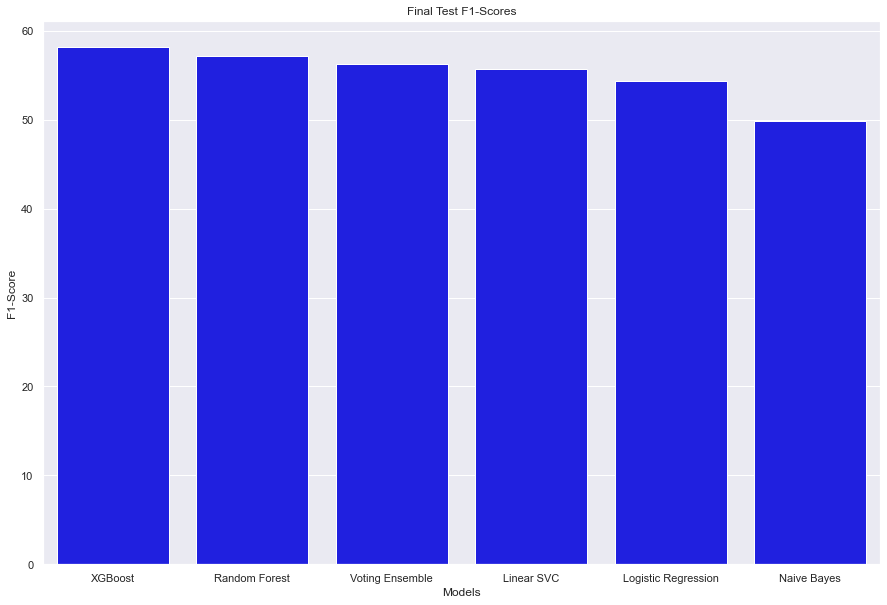

In [138]:
#Bar chart of the results
sns.set(rc = {'figure.figsize':(15,10)})
sns.barplot(x="Model", y = "F1", order = final_results["Model"] \
                                            , data = final_results, color = "blue")
plt.title("Final Test F1-Scores")
plt.ylabel("F1-Score")
plt.xlabel("Models")

In [140]:
#Rank the results by Accuracy
final_results.sort_values(by="Accuracy", ascending = False, inplace = True)
final_results

,Model,F1,Accuracy
3,Random Forest,57.142,91.315
4,XGBoost,58.228,90.913
5,Voting Ensemble,56.285,90.785
2,Linear SVC,55.660,90.548
0,Logistic Regression,54.363,89.811
1,Naive Bayes,49.874,87.357


Text(0.5, 0, 'Models')

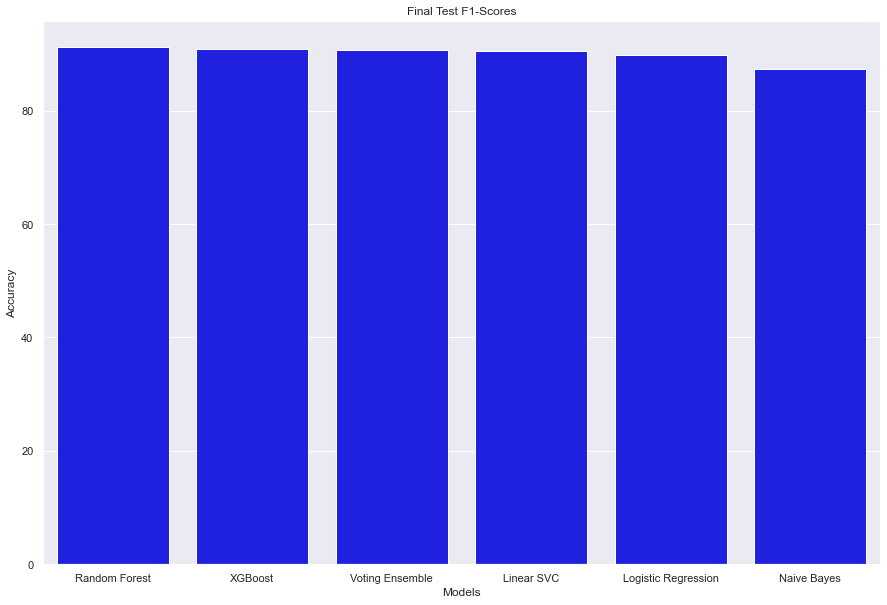

In [141]:
#Bar chart of the results
sns.set(rc = {'figure.figsize':(15,10)})
sns.barplot(x="Model", y = "Accuracy", order = final_results["Model"] \
                                            , data = final_results, color = "blue")
plt.title("Final Test F1-Scores")
plt.ylabel("Accuracy")
plt.xlabel("Models")

# Final Comments

Thus, we can see that the XGBoost model had the highest F1-score while Random Forest had the highest accuracy. However, all models gave very similar accuracy scores. Moreover, Naive Bayes was the only model to give a substantially smaller F1-score. Thus, the XGBoost model will be choosen to be put into production due to having the best F1 score and a reasonable time to fit. 

# Save the Best Model for Production

In [8]:
#Load the model with best hyperparameters
best_model = pickle.load(open("xgb_clf_model.sav", 'rb'))
best_model

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.45195454681591674,
              enable_categorical=False, gamma=0.546708263364187, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.38768070515882624, max_delta_step=None,
              max_depth=7, min_child_weight=25, missing=nan,
              monotone_constraints=None, n_estimators=195, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=0.6338249886045665,
              scale_pos_weight=None, subsample=0.7838501639099957,
              tree_method=None, use_label_encoder=False,
              validate_parameters=None, verbosity=None)

In [9]:
%%capture --no-stdout
#Clean the full data set
cd.chicago_data_cleaner(chicago, verbose = True)

Cleaning Started...

Successfully Cleaned Primary Type
Successfully Imputed Location
Successfully Cleaned Location
Successfully Added Month Column
Successfully Added Hour Column
Successfully Cleaned Community

Data Set Successfully Cleaned!


In [10]:
#Check for any missing values
chicago.isnull().sum()

unique_key              0
date                    0
primary_type            0
location_description    0
arrest                  0
domestic                0
year                    0
district_name           0
community_name          0
Month                   0
Hour                    0
dtype: int64

In [11]:
#Check the dimensions
chicago.shape

(2971592, 11)

In [14]:
#Predictor variables
cat_attribs = ["primary_type", "location_description", "domestic", "district_name", "community_name", "Month", "Hour"]
#Prepare the feature and target arrays
X, y = prepare_chicago_test(chicago, attribs=cat_attribs.copy())

In [15]:
#Check the dimensions
print(X.shape)
print(y.shape)

(2971592, 183)
(2971592,)


In [18]:
%%time
#Refit the best model on the entire data
best_model.fit(X, y)

[16:30:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 2min 16s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.45195454681591674,
              enable_categorical=False, gamma=0.546708263364187, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.38768070515882624, max_delta_step=0, max_depth=7,
              min_child_weight=25, missing=nan, monotone_constraints='()',
              n_estimators=195, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=0.6338249886045665,
              scale_pos_weight=1, subsample=0.7838501639099957,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [19]:
#Save the best model
pickle.dump(best_model, open("best_model.sav",'wb'))